<a href="https://colab.research.google.com/github/farhannaushad08/Deep-Learning-Journey/blob/main/CNN_04_Data_Augumentation_Cat_vs_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing dataset from kaggle**

In [2]:
import os
import zipfile

os.makedirs("/root/.kaggle", exist_ok=True)

!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


**Extract zip file**

In [4]:
import zipfile
with zipfile.ZipFile("cat-and-dog.zip", "r") as zip_ref:
    zip_ref.extractall("cat_and_dog_data")

**Importing essential library**

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


**Load the data using generator**

In [6]:
train_dir = "/content/cat_and_dog_data/training_set/training_set"
test_dir = "/content/cat_and_dog_data/test_set/test_set"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.
Class names: ['cats', 'dogs']


**Count Cats and Dogs (Before Augmentation)**

In [7]:
train_cats, train_dogs = 0, 0
for _, labels in train_ds:
    train_cats += tf.reduce_sum(1 - labels).numpy()
    train_dogs += tf.reduce_sum(labels).numpy()

test_cats, test_dogs = 0, 0
for _, labels in test_ds:
    test_cats += tf.reduce_sum(1 - labels).numpy()
    test_dogs += tf.reduce_sum(labels).numpy()

print("BEFORE AUGMENTATION:")
print(f"Training set - Cats: {int(train_cats)}, Dogs: {int(train_dogs)}")
print(f"Test set - Cats: {int(test_cats)}, Dogs: {int(test_dogs)}")


BEFORE AUGMENTATION:
Training set - Cats: 4000, Dogs: 4005
Test set - Cats: 1011, Dogs: 1012


**Visualize Some Training Images (Before Augmentation)**

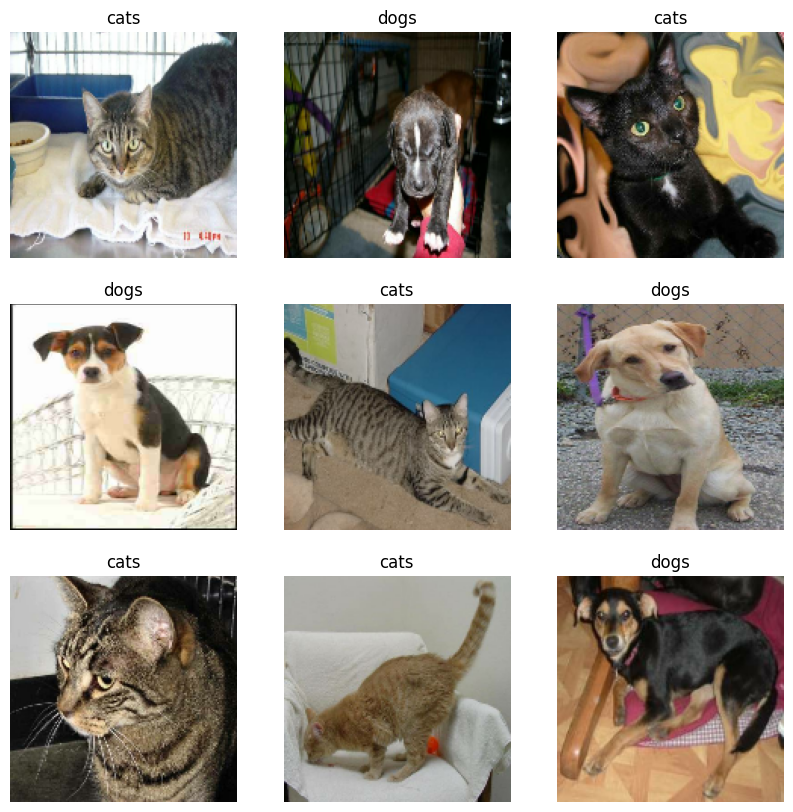

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


**Create Data Augmentation Layer**

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1)
])


**Apply Data Augmentation to Training Data**

In [10]:
# Map the augmentation to the dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


**Visualize Augmented Images**

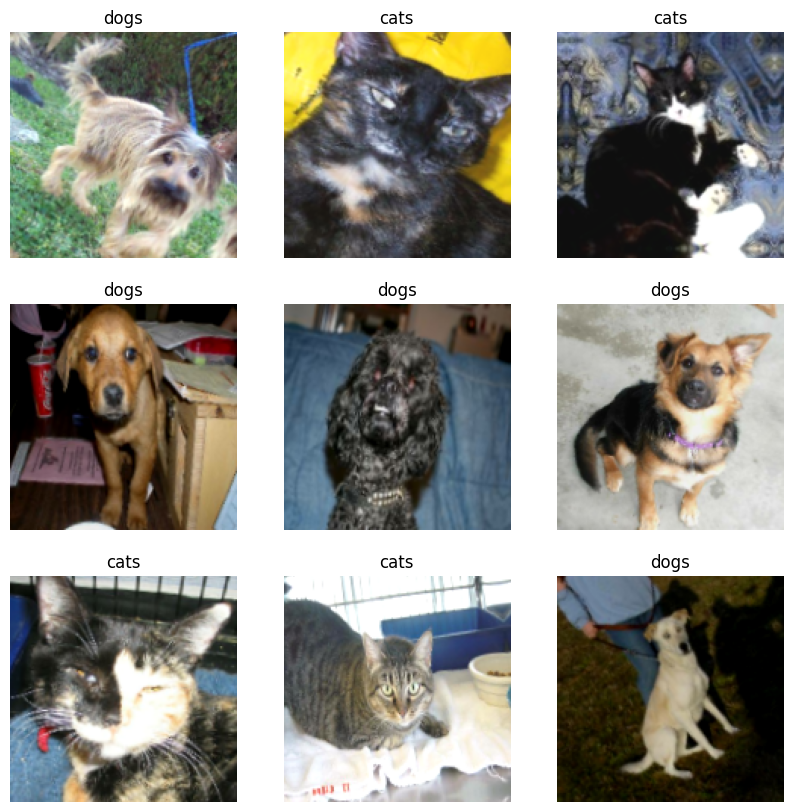

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


In [12]:
aug_cats, aug_dogs = 0, 0
for _, labels in augmented_train_ds:
    aug_cats += tf.reduce_sum(1 - labels).numpy()
    aug_dogs += tf.reduce_sum(labels).numpy()

print("AFTER AUGMENTATION:")
print(f"Training set - Cats: {int(aug_cats)}, Dogs: {int(aug_dogs)}")

AFTER AUGMENTATION:
Training set - Cats: 4000, Dogs: 4005


**Note:**
Augmentation doesn’t increase sample count — it just changes images dynamically each epoch (rotation, flip, etc.), helping your model generalize bette

**Normalize the the data between 0 and 1 and Prefetch for parallel processing**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
augmented_train_ds = augmented_train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# Cache & prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
augmented_train_ds = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


**BASELINE CNN MODEL**

In [14]:
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


**Train Model (Without Augmentation)**

In [16]:
model_no_aug = build_cnn_model()

history_no_aug = model_no_aug.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5443 - loss: 0.7342 - val_accuracy: 0.6787 - val_loss: 0.6000
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6958 - loss: 0.5813 - val_accuracy: 0.6678 - val_loss: 0.6246
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7476 - loss: 0.5179 - val_accuracy: 0.7617 - val_loss: 0.5039
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7879 - loss: 0.4449 - val_accuracy: 0.7781 - val_loss: 0.4831
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8348 - loss: 0.3713 - val_accuracy: 0.7889 - val_loss: 0.4573
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8660 - loss: 0.3075 - val_accuracy: 0.7766 - val_loss: 0.5233
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9015 - loss: 0.2407 - val_accuracy: 0.7899 - val_loss: 0.5349
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9296 - loss: 0.1786 - val_acc

**Train Model (With Augmentation)**

In [17]:
model_with_aug = build_cnn_model()

history_with_aug = model_with_aug.fit(
    augmented_train_ds,
    validation_data=test_ds,
    epochs=10
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.5296 - loss: 0.7691 - val_accuracy: 0.6120 - val_loss: 0.6750
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6380 - loss: 0.6386 - val_accuracy: 0.6762 - val_loss: 0.6104
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6667 - loss: 0.6105 - val_accuracy: 0.6891 - val_loss: 0.5963
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7172 - loss: 0.5479 - val_accuracy: 0.6846 - val_loss: 0.6041
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7482 - loss: 0.5164 - val_accuracy: 0.7365 - val_loss: 0.5339
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7775 - loss: 0.4593 - val_accuracy: 0.7548 - val_loss: 0.5256
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8194 - loss: 0.3970 - val_accuracy: 0.7336 - val_loss: 0.5959
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8513 - loss: 0.3284 - val_acc

**Plotting model perfromance**

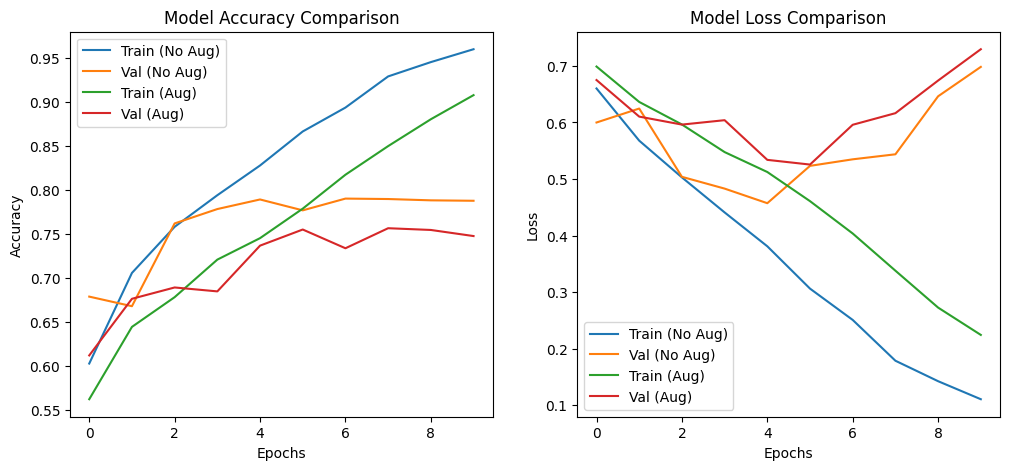

In [18]:
plt.figure(figsize=(12,5))

# Accuracy comparison
plt.subplot(1,2,1)
plt.plot(history_no_aug.history['accuracy'], label='Train (No Aug)')
plt.plot(history_no_aug.history['val_accuracy'], label='Val (No Aug)')
plt.plot(history_with_aug.history['accuracy'], label='Train (Aug)')
plt.plot(history_with_aug.history['val_accuracy'], label='Val (Aug)')
plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss comparison
plt.subplot(1,2,2)
plt.plot(history_no_aug.history['loss'], label='Train (No Aug)')
plt.plot(history_no_aug.history['val_loss'], label='Val (No Aug)')
plt.plot(history_with_aug.history['loss'], label='Train (Aug)')
plt.plot(history_with_aug.history['val_loss'], label='Val (Aug)')
plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


**Without Augmentation
Metric	Observation**

*   Training Accuracy	Starts at 54% → ends at 96%

*   Validation Accuracy	Peaks around 78–79%
*   Training Loss	Drops steadily to 0.10


*   Validation Loss	Starts low but increases to ~0.70

Interpretation:

*   The model overfits quickly.

*   Training accuracy is very high, but validation accuracy stagnates around 78–79%.
*   Validation loss increases, a classic overfitting signal.










**With Augmentation
Metric	Observation**

*   Training Accuracy	Starts at 53% → ends at 91%

*   Validation Accuracy	Peaks around 74–76%
*   Training Loss	Drops steadily to 0.22


*   Validation Loss	Starts low but increases to ~0.73

Interpretation:

*   Training accuracy is lower than the non-augmented model.

*   Validation accuracy is slightly more stable, even if slightly lower.
*   Model is generalizing better and is less likely to overfit in later epochs.

*   The slower rise in training accuracy is normal — augmentation makes the model see “new” variations every epoch, so it takes longer to fit.












**Evaluate on Test Data**

In [19]:
loss_no_aug, acc_no_aug = model_no_aug.evaluate(test_ds)
loss_with_aug, acc_with_aug = model_with_aug.evaluate(test_ds)

print("\n Final Test Accuracy Comparison:")
print(f"Without Augmentation: {acc_no_aug*100:.2f}%")
print(f"With Augmentation: {acc_with_aug*100:.2f}%")


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7823 - loss: 0.7883
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7220 - loss: 0.7911

 Final Test Accuracy Comparison:
Without Augmentation: 78.74%
With Augmentation: 74.74%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


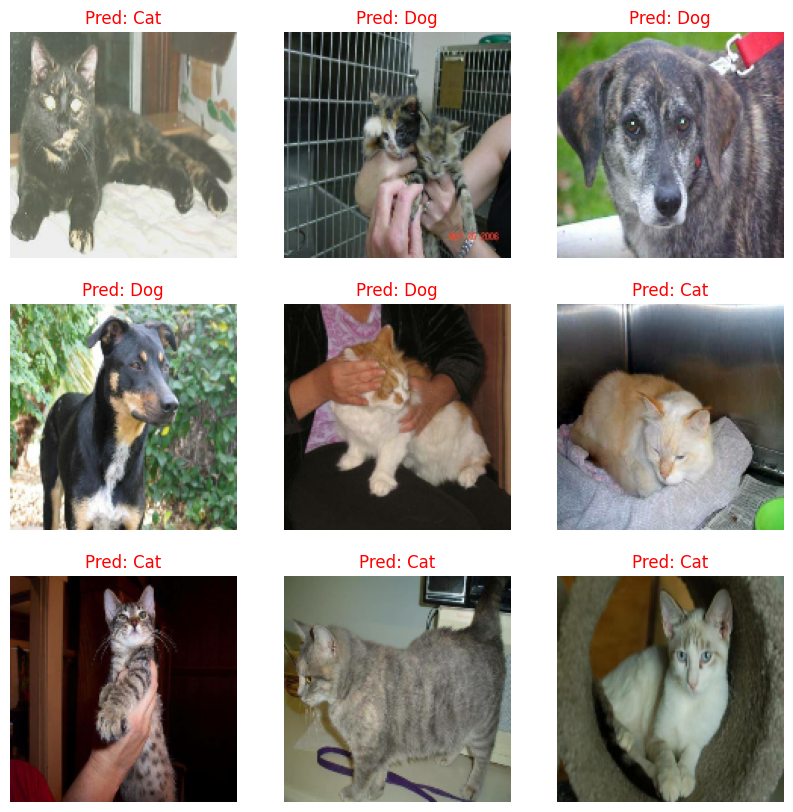

In [21]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    preds = model_with_aug.predict(images)
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        label = "Dog" if preds[i] > 0.5 else "Cat"
        color = "green" if label == class_names[int(labels[i])] else "red"
        plt.title(f"Pred: {label}", color=color)
        plt.axis("off")


Summary: Data Augmentation vs Non-Augmented Model

Data Augmentation:
- Reduces overfitting
- Provides better generalization to unseen images
- Slightly slows training accuracy, but improves robustness

Non-Augmented Model:
- Achieves very high training accuracy
- Overfits quickly → validation/test accuracy stagnates

Key Insight:
- Augmentation is crucial for real-world applications where test data may differ slightly from training data
